### Intrinsic Dimension Estimation with Local Full Correlation Integral (lFCI)
This notebook provides a modular pipeline for estimating the intrinsic dimension (ID) of datasets using the local Full Correlation Integral as proposed in "Exploring neural manifolds across a wide range of intrinsic dimensions"
 
The pipeline is designed to work with any dataset. 

#### 1. Imports and Configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from pathlib import Path
from typing import Dict, Any, Optional
import os

# Custom functions (you should have "lfci_functions.py" in the same directory)
from lfci_functions import extract_lfci_estimate, compute_local_fci


/opt/homebrew/anaconda3/envs/machine_learning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_id_results_simple(results: Dict[str, Any], save_path: Optional[str] = None):
    """
    Create visualization of ID estimation results.
    
    Parameters
    ----------
    results : Dict[str, Any]
        Results dictionary from run_id_pipeline
    save_path : Optional[str]
        Path to save the figure (if None, display only)
    """
    fig, axes = plt.subplots(3,1, figsize=(6, 9))
    data_name = results['data_name']
    lfci_raw = results['lfci_raw']
    lfci_processed = results['lfci_processed']
    all_deltas = lfci_raw['deltas']
    all_gof = lfci_raw['gof']
    all_id = lfci_raw['ids']
    all_k = lfci_raw['k']
    gof_thr = lfci_processed['gof_thr']
    est_id = lfci_processed['id_peak']
    density = lfci_processed['kde_density']
    x_range = lfci_processed['kde_x_range']
    optimal_k = lfci_processed['opt_k']
    
    # --- PLOT 1: Filtered vs unfiltered comparison (now in position 0,0) ---
    ax = axes[0]
    raw_data = lfci_raw['ids']
    filtered_idx = lfci_processed['filtered_indices']
    filtered_results = raw_data[filtered_idx] if len(filtered_idx) > 0 else np.array([])
    bins = np.linspace(filtered_results.min(), filtered_results.max(), 10)
    ax.hist(filtered_results, bins=bins, alpha=0.7, density = True, label='Filtered estimates', color='orange')
    ax.plot(x_range, density, linewidth=2, color='blue', label='KDE')
    ax.fill_between(x_range.flatten(), density, alpha=0.3, color='blue')
    ax.set_xlim(filtered_results.min()-1, filtered_results.max()+1)
    ax.axvline(est_id, color='red', linestyle='--', linewidth=2, label=f'Peak: {est_id:.2f}')
    ax.set_xlabel('ID Estimate', fontweight='bold')
    ax.set_ylabel('Count', fontweight='bold')
    ax.set_title('Effect of Quality Filtering', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # --- PLOT 2: Scatter plot: GoF vs Delta (now in position 0,1) ---
    ax = axes[1]
    # Apply filtering criteria
    delta_thr = results['parameters'].get('delta_thr', 2.0)
    cond = (all_deltas < delta_thr) & (all_gof < gof_thr)
    idx_good = np.where(cond)[0]
    if len(idx_good) == 0:
        print("No data matches GoF and delta thresholds.")
        # Plot rejected points
    else:
        # Create mask for filtered points
        all_indices = np.arange(len(all_deltas))
        good_mask = np.isin(all_indices, idx_good)
        
        # Plot accepted points
        scatter_accepted = ax.scatter(
            all_deltas[good_mask], 
            all_gof[good_mask], 
            c=all_id[good_mask], 
            cmap='viridis', 
            alpha=0.8,
            s=30,
            edgecolors='black',
            linewidths=0.8,
            label='Accepted',
            zorder=2
        )

        scatter_rejected = ax.scatter(
            all_deltas[~good_mask], 
            all_gof[~good_mask], 
            c=all_id[~good_mask], 
            cmap='viridis', 
            alpha=0.15,
            s=8,
            edgecolors='none',
            label='Rejected',
            zorder=1
        )

        # Add threshold lines
        ax.axhline(gof_thr, color='red', linestyle='--', linewidth=2, alpha=0.8, label=f'GoF thr: {gof_thr:.4f}',zorder=3)
        ax.axvline(delta_thr, color='red', linestyle=':', linewidth=2, alpha=0.8, label=f'Δ thr: {delta_thr}', zorder=3)
        # Add shaded region
        ax.fill_between([0, delta_thr], 0, gof_thr, color='green', alpha=0.15, label='Good region', zorder=0)
        
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', 
                      markerfacecolor='gray', markersize=8, 
                      alpha=0.3, label='Rejected'),
            plt.Line2D([0], [0], marker='o', color='w', 
                      markerfacecolor='blue', markersize=10,
                      markeredgecolor='black', label='Accepted'),
            plt.Line2D([0], [0], color='red', linestyle='--', 
                      linewidth=2, label=f'GoF thr: {gof_thr:.2f}'),
            plt.Line2D([0], [0], color='red', linestyle=':', 
                      linewidth=2, label=f'Δ thr: {delta_thr}')
        ]

        ax.legend(handles=legend_elements, loc='upper right', fontsize=9)
        plt.colorbar(scatter_accepted, ax=ax, label='ID Estimate')

    ax.set_xlabel(r'{$\delta} (Delta)', fontweight='bold')
    ax.set_ylabel('GoF (Goodness of Fit)', fontweight='bold')
    ax.set_title('Quality Metrics Scatter Plot', fontweight='bold')    
    ax.grid(True, alpha=0.3)

    # --- PLOT 3: Violin plot from data_visualisation.py (now in position 1,1) ---
    ax = axes[2]
    # Prepare data for violin plot (matching data_visualisation.py logic)
    k_flat = all_k.flatten()
    gof_flat = all_gof.flatten()
    # Get unique k values
    unique_k = np.unique(k_flat)
    k_values = unique_k
    # Group GoF values by k value
    all_gof_by_k = []
    for k in k_values:
        mask = (k_flat == k)
        gof_for_k = gof_flat[mask]
        all_gof_by_k.append(gof_for_k)
    # Find maximum length for violin plot
    max_len = max(len(arr) for arr in all_gof_by_k if len(arr) > 0)
    # Create 2D array with NaN padding
    violin_data = np.full((max_len, len(k_values)), np.nan)
    for i, k in enumerate(k_values):
        gof_arr = all_gof_by_k[i]
        if len(gof_arr) > 0:
            violin_data[:len(gof_arr), i] = gof_arr
    
    # Remove columns with no data
    valid_columns = [i for i in range(len(k_values)) if not np.all(np.isnan(violin_data[:, i]))]
    violin_data_valid = violin_data[:, valid_columns]
    k_values_valid = k_values[valid_columns]
    
    # Create violin plot if we have valid data
    if len(k_values_valid) > 0:
        positions = np.arange(1, len(k_values_valid) + 1)
        
        # Create main violin plot
        parts0 = ax.violinplot(violin_data_valid, showextrema=False, widths=0.7)
        
        # Style all violins with blue color
        for pc in parts0['bodies']:
            pc.set_facecolor("C0")
            pc.set_edgecolor("C0")
            pc.set_alpha(0.8)
    
        # Highlight optimal k violin if it's in valid k values
        if optimal_k in k_values_valid:
            opt_k_idx = np.where(k_values_valid == optimal_k)[0][0]
            parts = ax.violinplot(
                violin_data_valid[:, opt_k_idx], 
                positions=[positions[opt_k_idx]],
                showextrema=False, 
                widths=1
            )
            
            # Style the highlighted violin with red color
            for pc in parts['bodies']:
                pc.set_facecolor('r')
                pc.set_edgecolor('r')
                pc.set_alpha(1)
        
        # Set x-axis ticks and labels
        ax.set_xticks(positions)
        ax.set_xticklabels(k_values_valid.astype(int), rotation=90)
    
    # Add horizontal dashed line at GoF threshold
    ax.axhline(gof_thr, color='k', linestyle='dashed', linewidth=2, label=f'GoF threshold: {gof_thr:.4f}')
    # Add shaded region
    ax.axhspan(0, gof_thr, alpha=0.1, color='green', label='Good fit region')
    # Add grid
    ax.grid(True, alpha=0.3)
    # Label axes
    ax.set_xlabel("k (Number of Neighbors)", fontweight='bold')
    ax.set_ylabel("GoF (Goodness of Fit)", fontweight='bold')
    ax.set_title("GoF Distribution vs k", fontweight='bold')
    ax.legend(loc='upper right')
    
    # Adjust layout and save
    plt.suptitle(f'Intrinsic Dimension Estimation: {data_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()

 #### 9. Use the pipeline with custom data

In [ ]:
# 1. Load your data and setup output directory path
your_data = np.random.randn(1000, 20) # Random gaussian placeholder. Replace with your actual data loading
your_data_name = "random_gaussian" #placeholder name change based on your data and parameters
output_dir="results"
os.mkdir(output_dir) if not os.path.exists(output_dir) else None

#1. Analyze data with local full correlation integral (lFCI) method
# Set lFCI parameters
lfci_params = {
    'n_neighbors': 10, # Adjust based on your data size. 
    'n_centers': 30, # Increase for more statistics. Computational time increases linearly Should be smaller than total number of samples
    'fci_method': 'full',
    'n_jobs': 1,
    'delta_thr': 2.0, # principled threshold. More detailes in "Exploring neural manifolds across a wide range of intrinisc dimensions"
    'ci_interval': (10, 90) # 80% confidence interval
}

# 2. Compute local FCI estimates
print("\n2. Computing local FCI estimates...")

ids, deltas, k, gof, neighborhoods = compute_local_fci(
    dataset = your_data,
    n_neighbors=lfci_params['n_neighbors'],
    n_centers=lfci_params['n_centers'],
    fci_method=lfci_params['fci_method'],
    n_jobs=lfci_params['n_jobs']
)

quartiles_delta = np.percentile(deltas, [5, 50, 99])
hist_delta, edges_delta = np.histogram(deltas, bins=100)
quartiles_gof = np.percentile(gof, [5, 50, 99])

print(f"   Computed {len(ids)} local estimates")



2. Computing local FCI estimates...
   Computed 300 local estimates


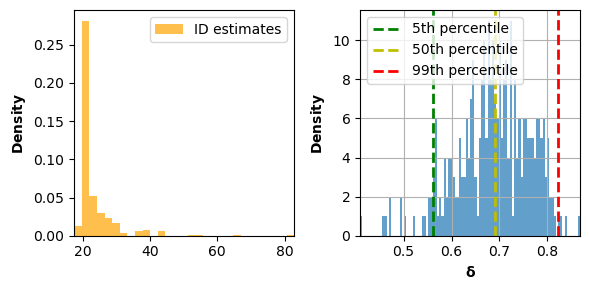

In [4]:
#3. Visualize raw lfci results
bins = np.linspace(ids.min(), ids.max(), 30)
fig, ax = plt.subplots(1,2, figsize=(6,3))
bin_centers_d = (edges_delta[:-1] + edges_delta[1:])/2
#ax.plot(bin_centers_d, hist_delta, '.-')


ax[0].hist(ids, bins=bins, alpha=0.7, density = True, label='ID estimates', color='orange')
ax[0].legend()
ax[0].set_xlim(ids.min(), ids.max())
ax[0].set_ylabel(r"$\mathbf{Density}$")

ax[1].bar(bin_centers_d, hist_delta, width=np.diff(edges_delta), alpha=0.7)
ax[1].axvline(quartiles_delta[0], color='g', linestyle='dashed', linewidth=2, label='5th percentile')
ax[1].axvline(quartiles_delta[1], color='y', linestyle='dashed', linewidth=2, label='50th percentile')
ax[1].axvline(quartiles_delta[2], color='r', linestyle='dashed', linewidth=2, label='99th percentile')
ax[1].set_xlim(min(deltas),max(deltas))
ax[1].legend()
ax[1].set_xlabel(r"$\mathbf{\delta}$")
ax[1].set_ylabel(r"$\mathbf{Density}$")
ax[1].grid()
plt.tight_layout()
plt.savefig(f"{output_dir}/{your_data_name}_raw_lfc_analysis.pdf")

 ### Tips for parameter tuning:
 1. **n_neighbors**: Should cover a range from small to large neighborhoods. 
    Logarithmic spacing is usually good.
 2. **n_centers**: More centers give better statistics but increase computation.
 3. **delta_thr**: For completely isotropic data, the 99th percentile of delta values is lower than 2. See paper for more details.
 4. **n_jobs**: Set to -1 to use all available CPU cores.


3. Extracting lFCI estimate with quality filters...
   GoF threshold determined: 0.0004998298891587183 as 99th percentile at k = 630.0
   lFCI peak estimate: 20.010
   Confidence interval: [19.928, 20.071]
   Points after filtering: 32/300
Plot saved to: results/Random Gaussian_id_estimation_results.png


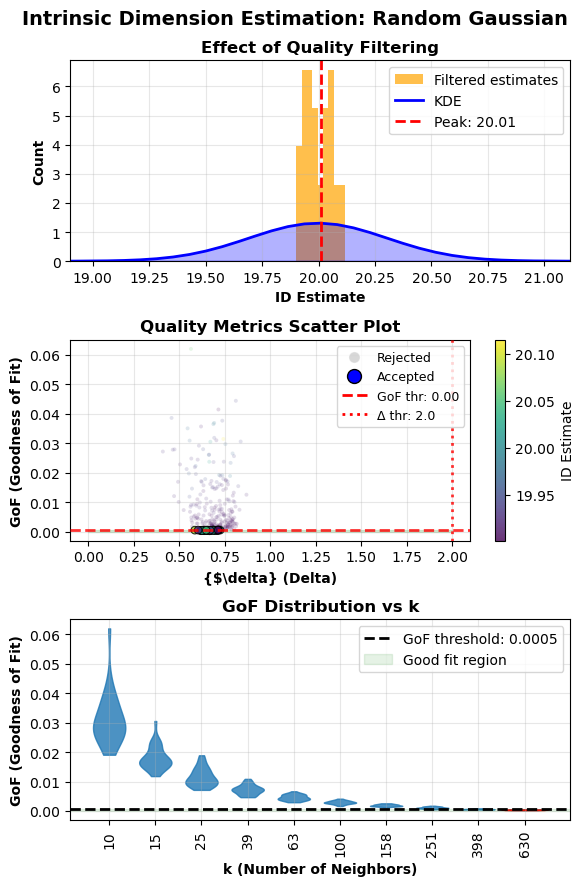

In [5]:
# 3. Filter lFCI by quality and extract estimate

# Set KDE parameters for lFCI extraction
KDE_params = {
            'bandwidth': 0.3,
            'x_min': ids.min(), #canghe based on observed ID range. Observed ID range should be within [x_min, x_max]
            'x_max': ids.max(), #change based on observed ID range
            'n_points_peak': 900
        }

print("\n3. Extracting lFCI estimate with quality filters...")

lfci_processed = extract_lfci_estimate(
    ids, deltas, k, gof, neighborhoods,
    delta_thr=lfci_params['delta_thr'],
    ci_interval=lfci_params['ci_interval'],
    KDE_params=KDE_params
)

gof_thr = lfci_processed['gof_thr']
est_id = lfci_processed['id_peak']
density = lfci_processed['kde_density']
x_range = lfci_processed['kde_x_range']
ci = lfci_processed['ci_id']
filtered_idx = lfci_processed['filtered_indices']

print(f"   lFCI peak estimate: {est_id:.3f}")
print(f"   Confidence interval: [{ci[0]:.3f}, {ci[1]:.3f}]")
print(f"   Points after filtering: {lfci_processed['n_filtered']}/{len(ids)}")

filtered_results = ids[filtered_idx] if len(filtered_idx) > 0 else np.array([])

if len(filtered_results) == 0:
    print("No data points passed the filtering criteria.")
else:
    results = {
        'data_name': your_data_name,
        'data_shape': your_data.shape,
        'lfci_raw': {
            'ids': ids,
            'deltas': deltas,
            'k': k,
            'gof': gof
        },
        'lfci_processed': lfci_processed,
        'parameters': lfci_params,
    }
    plot_id_results_simple(results, save_path=f"{output_dir}/{your_data_name}_id_estimation_results.png")



In [6]:

# 4. Save results if requested
filename = f"{output_dir}/{your_data_name}.h5"
with h5py.File(filename, 'w') as f:
    # Save metadata
    f.attrs['data_name'] = your_data_name
    f.attrs['data_shape'] = your_data.shape
    
    # Save raw lFCI data
    f.create_dataset('lfci_ids', data=ids)
    f.create_dataset('lfci_deltas', data=deltas)
    f.create_dataset('lfci_k', data=k)
    f.create_dataset('lfci_gof', data=gof)
    
    # Save processed results
    f.attrs['lfci_gof_thr'] = lfci_processed['gof_thr']
    f.attrs['lfci_id_peak'] = lfci_processed['id_peak']
    f.attrs['lfci_ci_lower'] = lfci_processed['ci_id'][0]
    f.attrs['lfci_ci_upper'] = lfci_processed['ci_id'][1]

print(f"\nResults saved to: {filename}")



Results saved to: results/Random Gaussian.h5
